# 0. Importing Libraries

In [1]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy
print(numpy.__version__)

1.26.4


In [4]:
import spacy

In [5]:
print(spacy.__version__)

3.5.0


In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time
import datasets
import matplotlib.pyplot as plt
import torch.optim as optim

# Set device as GPU if available, else set to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Jue\Desktop\NLP\A3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


# 1. ETL: Loading dataset

In [2]:
import datasets

# Processed TALPCo dataset
corpus = datasets.load_dataset('minnbanya/en-my-nlp-a3')

In [3]:
corpus

DatasetDict({
    train: Dataset({
        features: ['en', 'my'],
        num_rows: 1093
    })
    validation: Dataset({
        features: ['en', 'my'],
        num_rows: 137
    })
    test: Dataset({
        features: ['en', 'my'],
        num_rows: 137
    })
})

## Extract language pair

In [4]:
SRC_LANGUAGE = 'en' # English
TRG_LANGUAGE = 'my' # Myanmar

In [5]:
corpus['train'][0][SRC_LANGUAGE]

'I drank a little bit of alcohol yesterday'

In [6]:
corpus['train'][0][TRG_LANGUAGE]

'မနေ့က အရက် နည်းနည်း သောက်ခဲ့တယ်။'

# 2. Preprocessing

## Tokenization, Numericalization

In [7]:
# Place-holders
token_transform = {}
vocab_transform = {}

## Myanmar segmentation tool (myWord)

In [8]:
import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

# Myanmar syllable combination dictionaries (pretrained)
UNI_DICT_BIN = './app/data/unigram-word.bin'
BI_DICT_BIN = './app/data/bigram-word.bin'                

def read_dict(file_path):
    """Reads a binary dictionary file and returns its contents."""
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except FileNotFoundError:
        print(f"Dictionary file {file_path} not found!")
        return {}

class ProbDist(dict):
    """Probability distribution estimated from unigram/bigram data."""
    
    def __init__(self, datafile=None, unigram=True, total_count=102490):
        super().__init__()
        data = read_dict(datafile)
        self.update(data)
        self.total_count = total_count

        self.unknown_prob = (
            lambda word, N: 10 / (N * 10**len(word)) if unigram else lambda _, N: 1 / N
        )

    def __call__(self, key):
        """Returns the probability of a word, falling back on unknown probability estimation."""
        return self.get(key, 0) / self.total_count if key in self else self.unknown_prob(key, self.total_count)

# Load probability distributions
P_UNIGRAM = ProbDist(UNI_DICT_BIN, unigram=True)
P_BIGRAM = ProbDist(BI_DICT_BIN, unigram=False)

def conditional_prob(current_word, previous_word):
    """Computes conditional probability P(current_word | previous_word)."""
    bigram = f"{previous_word} {current_word}"
    return P_BIGRAM[bigram] / P_UNIGRAM[previous_word] if bigram in P_BIGRAM else P_UNIGRAM(current_word)

@functools.lru_cache(maxsize=2**10)
def viterbi(text, previous_word="<S>", max_length=20):
    """Viterbi algorithm for word segmentation based on maximum probability."""
    if not text:
        return 0.0, []

    max_length = min(len(text), max_length)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(max_length)]

    candidates = [
        (
            math.log10(conditional_prob(first_word, previous_word)) + remain_prob,
            [first_word] + remain_words
        )
        for first_word, remaining_text in splits
        for remain_prob, remain_words in [viterbi(remaining_text, first_word)]
    ]

    return max(candidates, key=lambda x: x[0])


In [13]:
import math
import functools
import sys
import pickle

sys.setrecursionlimit(10**6)

# Myanmar syllable combination dictionaries (pretrained)
uni_dict_bin = './app/data/unigram-word.bin'
bi_dict_bin = './app/data/bigram-word.bin'                

# Read binary files
def read_dict (fileDICT):
    try:
        with open(fileDICT, 'rb') as input_file:
            dictionary = pickle.load(input_file)
            input_file.close()
    except FileNotFoundError:
        print('Dictionary file', fileDICT, ' not found!')
    return dictionary

class ProbDist(dict):
    ### Probability distribution estimated from unigram/bigram data
    def __init__(self, datafile=None, unigram=True, N=102490):
        data = read_dict(datafile)
        for k, c in data.items():
            self[k] = self.get(k, 0) + c

        if unigram:
            self.unknownprob = lambda k, N: 10/(N*10**len(k))    # avoid unknown long word
        else:
            self.unknownprob = lambda k, N: 1/N

        self.N = N

    def __call__(self, key):
        if key in self:
            return self[key]/self.N
        else:
            return self.unknownprob(key, self.N)
        
P_unigram = ProbDist(uni_dict_bin, True)
P_bigram = ProbDist(bi_dict_bin, False)

def conditionalProb(word_curr, word_prev):
    ### Conditional probability of current word given the previous word.
    try:
        return P_bigram[word_prev + ' ' + word_curr]/P_unigram[word_prev]
    except KeyError:
        return P_unigram(word_curr)

@functools.lru_cache(maxsize=2**10)
#maxlen=20
def viterbi(text, prev='<S>', maxlen=20):
    if not text:
        return 0.0, []
    
    textlen = min(len(text), maxlen)
    splits = [(text[:i + 1], text[i + 1:]) for i in range(textlen)]

    candidates = []

    for first_word, remain_word in splits:

        first_prob = math.log10(conditionalProb(first_word, prev))

        remain_prob, remain_word = viterbi(remain_word, first_word)

        candidates.append((first_prob + remain_prob, [first_word] + remain_word))

    return max(candidates)

In [9]:
def my_tokenizer(text):
    """Myanmar tokenizer using Viterbi segmentation."""
    if not text:
        return []  # Handle None or empty input gracefully

    word_delimiter = '|'  # Define the word delimiter
    processed_text = text.replace(" ", "").strip()  # Remove spaces before processing

    # Perform Viterbi segmentation
    _, segmented_words = viterbi(processed_text)

    # Join words with delimiter, clean up formatting, and split back into a list
    cleaned_text = word_delimiter.join(segmented_words).strip(word_delimiter)
    return cleaned_text.split(word_delimiter)


In [14]:
def my_tokenizer(text): # Myanmar tokenizer
    if text is None: # Handle null value as empty string
        return []
    wordDelimiter= '|' # assign local variable delimiter

    input = text[:]
    listString = viterbi(input.replace(" ", "").strip()) # remove space between words and pass to viterbi()
    wordStr = wordDelimiter.join(listString[1])
    wordClean1=wordStr.strip()
    wordClean2=wordClean1.strip(wordDelimiter)    
    wordClean2 = wordClean2.split('|')                
    return wordClean2

## Tokenizers

In [10]:
print("Torch Version:", torch.__version__)
print("TorchText Version:", torchtext.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

Torch Version: 2.2.0+cu118
TorchText Version: 0.17.0+cpu
CUDA Available: True
CUDA Version: 11.8


In [11]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = my_tokenizer

## Special token indices

In [12]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Build vocab

In [13]:
def yield_tokens(data, language):
    """Yields tokenized sequences from input data.

    Args:
        data (list or None): The dataset containing samples, where each sample can be a list or a dictionary.
        language (str): The target language for tokenization.

    Yields:
        list: Tokenized words for each sample.
    """
    if not data:  # Handle None or empty data gracefully
        return

    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list):
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample.get(language, ""))


In [19]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    if data is None: # handle null value
        return []
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if isinstance(data_sample, list): # handle list
            yield token_transform[language](data_sample[language_index[language]])
        elif isinstance(data_sample, dict):
            yield token_transform[language](data_sample[language])

In [14]:
from torchtext.vocab import build_vocab_from_iterator

# Build vocabularies for source and target languages
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang] = build_vocab_from_iterator(
        yield_tokens(corpus['train'], lang), 
        min_freq=2,  # Tokens appearing less than twice will be treated as UNK
        specials=special_symbols,
        special_first=True  # Insert special tokens at the beginning
    )

# Set the default index for unknown tokens (UNK)
for lang in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[lang].set_default_index(UNK_IDX)


In [20]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(corpus['train'], ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [15]:
import pickle

pickle.dump(vocab_transform, open('./app/data/vocab.pkl', 'wb'))

In [16]:
vocab_transform = pickle.load(open('./app/data/vocab.pkl', 'rb'))

## Batching

In [17]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16  # GPU memory limitation

# Helper function to apply sequential transformations
def sequential_transforms(*transforms):
    """Applies a sequence of transformations to the input text."""
    def func(txt_input):
        if not txt_input:  # Handle None or empty input
            return []
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Function to add BOS/EOS and convert to tensor
def tensor_transform(token_ids):
    """Adds BOS (start-of-sequence) and EOS (end-of-sequence) tokens and converts to tensor."""
    return torch.cat((
        torch.tensor([SOS_IDX], dtype=torch.int64),
        torch.tensor(token_ids, dtype=torch.int64),
        torch.tensor([EOS_IDX], dtype=torch.int64)
    ))

# Define text transformations for source and target languages
text_transform = {
    lang: sequential_transforms(
        token_transform[lang],  # Tokenization
        vocab_transform[lang],  # Numericalization
        tensor_transform        # Add BOS/EOS and create tensor
    )
    for lang in [SRC_LANGUAGE, TRG_LANGUAGE]
}

# Collate function for batching data
def collate_batch(batch):
    """Collates data samples into padded batches with lengths."""
    src_batch, src_len_batch, trg_batch = [], [], []

    for lang_data in batch:
        for lang, tokens in lang_data.items():
            # Convert tokens to tensor, handling None or empty input safely
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)

    # Pad source and target sequences
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True) if src_batch else torch.empty(0)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True) if trg_batch else torch.empty(0)

    # Adjust empty sequences to maximum length in the batch
    max_len = src_batch.size(1) if src_batch.numel() > 0 else 0
    src_len_batch = [length if length > 0 else max_len for length in src_len_batch]

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


In [23]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # GPU memory limitation

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        if txt_input is None:
            return []
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for lang_data in batch:
        # Assuming that each language is a key in the dictionary
        for lang, tokens in lang_data.items():
            # Use an empty tensor as a default value if tokens is None or an empty list
            processed_text = text_transform[lang](tokens) if tokens else torch.empty(0, dtype=torch.int64)
            
            # For source language, append to src_batch and record length
            if lang == SRC_LANGUAGE:
                src_batch.append(processed_text)
                src_len_batch.append(processed_text.size(0))
            
            # For target language, append to trg_batch
            elif lang == TRG_LANGUAGE:
                trg_batch.append(processed_text)

    # Pad sequences
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True)

    # Set the length of empty sequences to the maximum length
    max_len = max(src_batch.size(0), max(src_len_batch))
    src_len_batch = [length if length > 0 else max_len for length in src_len_batch]


    
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)

    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [18]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = BATCH_SIZE

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(
    corpus['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
valid_loader = DataLoader(
    corpus['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)
test_loader = DataLoader(
    corpus['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

# Alternative (if using a different test corpus)
# train_loader = DataLoader(corpus_test, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)


In [24]:
batch_size = BATCH_SIZE

train_loader = DataLoader(corpus['train'], batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)
valid_loader = DataLoader(corpus['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(corpus['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# train_loader = DataLoader(corpus_test, batch_size=batch_size, shuffle=True,  collate_fn=collate_batch)

In [19]:
for en, _, my in train_loader:
    break

In [20]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("Myanmar shape: ", my.shape)   # (seq len, batch_size)

English shape:  torch.Size([16, 15])
Myanmar shape:  torch.Size([16, 17])


# 3. Model

## Encoder

### Encoder layer

In [27]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

In [21]:
import torch
import torch.nn as nn

class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        """
        Transformer Encoder Layer.

        Args:
            hid_dim (int): Hidden dimension size.
            n_heads (int): Number of attention heads.
            pf_dim (int): Position-wise feedforward layer dimension.
            dropout (float): Dropout rate.
            device (torch.device): Computation device.
            mech (str): Mechanism for multi-head attention.
        """
        super().__init__()

        # Layer Normalization
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Attention and Feedforward Layers
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        """
        Forward pass for an encoder layer.

        Args:
            src (torch.Tensor): Input sequence tensor of shape [batch_size, src_len, hid_dim].
            src_mask (torch.Tensor): Source mask tensor of shape [batch_size, 1, 1, src_len].

        Returns:
            torch.Tensor: Encoded representation of shape [batch_size, src_len, hid_dim].
        """
        # Self-Attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))  # Residual Connection & Layer Norm

        # Feedforward Layer
        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))  # Residual Connection & Layer Norm

        return src


### Encoder

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, 
                 mech, max_length = 1000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device, mech)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        return src

## Multihead Attention layer

In [29]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, mech):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.mech = mech # attention mechanism selector
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        # for additive attention
        self.v        = nn.Linear(self.head_dim, 1)                 
        self.W        = nn.Linear(self.head_dim, self.head_dim) # reused in multiplicative attention
        self.U        = nn.Linear(self.head_dim, self.head_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        
        batch_size = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim] when self attention
        #Q = [batch_size, query len, hid_dim], K=V = [batch_size, key len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        #K=V = [batch_size, n heads, key len, head_dim]

        if self.mech == 'gen': # general attention
            # e = Q @ K
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
            #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
            #energy = [batch_size, n heads, query len, key len]

        elif self.mech == 'mul': # multiplicative attention
            # e = Q @ W(K)
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale
            #Q = [batch_size, n heads, query len, head_dim] @ W(K = [batch_size, n heads, head_dim, key len])
            #energy = [batch_size, n heads, query len, key len]
        
        elif self.mech == 'add': # additive attention
            # add extra dimensions to allow addition
            Q = Q.view(batch_size, self.n_heads, query_len, 1, self.head_dim)
            K = K.view(batch_size, self.n_heads, 1, key_len, self.head_dim)
            # Q = [batch_size, n heads, query len, 1, head_dim]
            # K = [batch_size, n heads, 1, key len, head_dim]
            
            q = self.W(Q)
            k = self.U(K)

            # e = v ( tanh( W(Q) + U(K) ) )
            energy = self.v(torch.tanh(q + k)) / self.scale
            #energy = [batch_size, n heads, query len, key len, 1]

            energy = energy.squeeze(4)
            #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention

## Decoder

### Decoder layer

In [22]:
import torch
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, mech):
        """
        Multi-Head Attention Layer supporting different attention mechanisms.

        Args:
            hid_dim (int): Hidden dimension size.
            n_heads (int): Number of attention heads.
            dropout (float): Dropout rate.
            device (torch.device): Computation device.
            mech (str): Attention mechanism selector ('gen', 'mul', 'add').
        """
        super().__init__()

        assert hid_dim % n_heads == 0, "hid_dim must be divisible by n_heads"

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.mech = mech  # Attention mechanism type

        # Linear projections for Query, Key, and Value
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        # Additional layers for additive attention
        self.v = nn.Linear(self.head_dim, 1)
        self.W = nn.Linear(self.head_dim, self.head_dim)  # Used in multiplicative attention
        self.U = nn.Linear(self.head_dim, self.head_dim)

        # Final output projection
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask=None):
        """
        Forward pass for multi-head attention.

        Args:
            query (torch.Tensor): Query tensor of shape [batch_size, query_len, hid_dim].
            key (torch.Tensor): Key tensor of shape [batch_size, key_len, hid_dim].
            value (torch.Tensor): Value tensor of shape [batch_size, value_len, hid_dim].
            mask (torch.Tensor, optional): Attention mask of shape [batch_size, 1, 1, key_len].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, query_len, hid_dim].
            torch.Tensor: Attention weights of shape [batch_size, n_heads, query_len, key_len].
        """
        batch_size, query_len, _ = query.shape
        key_len = key.shape[1]

        # Apply linear projections
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Reshape into multiple heads
        Q = Q.view(batch_size, query_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, key_len, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Shape: [batch_size, n_heads, seq_len, head_dim]

        # Compute attention scores based on selected mechanism
        if self.mech == 'gen':  # General attention
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'mul':  # Multiplicative attention
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale
        elif self.mech == 'add':  # Additive attention
            # Reshape Q and K for element-wise addition
            Q = Q.unsqueeze(3)  # [batch_size, n_heads, query_len, 1, head_dim]
            K = K.unsqueeze(2)  # [batch_size, n_heads, 1, key_len, head_dim]

            # Compute energy using additive attention formula
            energy = self.v(torch.tanh(self.W(Q) + self.U(K))) / self.scale
            energy = energy.squeeze(-1)  # Remove last dimension to match [batch_size, n_heads, query_len, key_len]

        # Apply mask if provided (e.g., padding mask)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        # Compute attention weights
        attention = torch.softmax(energy, dim=-1)

        # Apply attention to values
        x = torch.matmul(self.dropout(attention), V)

        # Reshape back to original size
        x = x.permute(0, 2, 1, 3).contiguous()  # [batch_size, query_len, n_heads, head_dim]
        x = x.view(batch_size, query_len, self.hid_dim)  # Merge heads

        # Final linear projection
        x = self.fc_o(x)

        return x, attention


In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

In [23]:
import torch
import torch.nn as nn

class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device, mech):
        """
        Transformer Decoder Layer.

        Args:
            hid_dim (int): Hidden dimension size.
            n_heads (int): Number of attention heads.
            pf_dim (int): Position-wise feedforward layer dimension.
            dropout (float): Dropout rate.
            device (torch.device): Computation device.
            mech (str): Attention mechanism selector.
        """
        super().__init__()

        # Layer Normalization
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        # Multi-Head Attention Layers
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device, mech)

        # Feedforward Layer
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Forward pass for the Transformer decoder layer.

        Args:
            trg (torch.Tensor): Target sequence tensor of shape [batch_size, trg_len, hid_dim].
            enc_src (torch.Tensor): Encoded source sequence of shape [batch_size, src_len, hid_dim].
            trg_mask (torch.Tensor): Target mask of shape [batch_size, 1, trg_len, trg_len].
            src_mask (torch.Tensor): Source mask of shape [batch_size, 1, 1, src_len].

        Returns:
            torch.Tensor: Decoded representation of shape [batch_size, trg_len, hid_dim].
            torch.Tensor: Attention weights of shape [batch_size, n_heads, trg_len, src_len].
        """
        # Self-Attention (Masked)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        # Encoder-Decoder Attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        # Feedforward Network
        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))  # Residual Connection + Layer Norm

        return trg, attention


### Decoder

In [31]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, mech, max_length = 1000):
        super().__init__()
        self.device = device
        self.mech = mech
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, mech)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        # print(trg.shape, self.scale, self.tok_embedding, self.pos_embedding)
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        # print(attention.shape)
        return output, attention

In [24]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device, mech, max_length=1000):
        """
        Transformer Decoder.

        Args:
            output_dim (int): Vocabulary size of the output language.
            hid_dim (int): Hidden dimension size.
            n_layers (int): Number of decoder layers.
            n_heads (int): Number of attention heads.
            pf_dim (int): Position-wise feedforward layer dimension.
            dropout (float): Dropout rate.
            device (torch.device): Computation device.
            mech (str): Attention mechanism selector.
            max_length (int, optional): Maximum sequence length. Defaults to 1000.
        """
        super().__init__()

        self.device = device
        self.mech = mech

        # Embedding layers
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        # Decoder layers
        self.layers = nn.ModuleList([
            DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device, mech)
            for _ in range(n_layers)
        ])

        # Final output layer
        self.fc_out = nn.Linear(hid_dim, output_dim)

        # Dropout and scaling
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        """
        Forward pass for the Transformer decoder.

        Args:
            trg (torch.Tensor): Target sequence tensor of shape [batch_size, trg_len].
            enc_src (torch.Tensor): Encoded source sequence of shape [batch_size, src_len, hid_dim].
            trg_mask (torch.Tensor): Target mask of shape [batch_size, 1, trg_len, trg_len].
            src_mask (torch.Tensor): Source mask of shape [batch_size, 1, 1, src_len].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, trg_len, output_dim].
            torch.Tensor: Attention weights of shape [batch_size, n_heads, trg_len, src_len].
        """
        batch_size, trg_len = trg.shape

        # Create positional encodings
        pos = torch.arange(0, trg_len, device=self.device).unsqueeze(0).repeat(batch_size, 1)

        # Apply token and positional embeddings
        trg = self.dropout(self.tok_embedding(trg) * self.scale + self.pos_embedding(pos))

        # Pass through decoder layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # Compute final output
        output = self.fc_out(trg)

        return output, attention


### Positional Feedforward layer

In [25]:
import torch
import torch.nn as nn

class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        """
        Position-wise Feedforward Layer.

        Args:
            hid_dim (int): Hidden dimension size.
            pf_dim (int): Intermediate feedforward dimension.
            dropout (float): Dropout rate.
        """
        super().__init__()

        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, x):
        """
        Forward pass of the feedforward layer.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, seq_len, hid_dim].

        Returns:
            torch.Tensor: Output tensor of shape [batch_size, seq_len, hid_dim].
        """
        return self.fc2(self.dropout(self.activation(self.fc1(x))))


In [32]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

## Seq2Seq

In [33]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        return output, attention

In [26]:
import torch
import torch.nn as nn

class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        """
        Transformer-based Sequence-to-Sequence Model.

        Args:
            encoder (nn.Module): Encoder module.
            decoder (nn.Module): Decoder module.
            src_pad_idx (int): Padding index for the source sequence.
            trg_pad_idx (int): Padding index for the target sequence.
            device (torch.device): Computation device.
        """
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        """
        Creates a source mask to ignore padding tokens.

        Args:
            src (torch.Tensor): Source sequence of shape [batch_size, src_len].

        Returns:
            torch.Tensor: Source mask of shape [batch_size, 1, 1, src_len].
        """
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg):
        """
        Creates a target mask with padding and look-ahead masking.

        Args:
            trg (torch.Tensor): Target sequence of shape [batch_size, trg_len].

        Returns:
            torch.Tensor: Target mask of shape [batch_size, 1, trg_len, trg_len].
        """
        batch_size, trg_len = trg.shape

        # Padding mask: Ignore padded tokens
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # Look-ahead mask: Prevent attending to future tokens
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        # Combine both masks
        return trg_pad_mask & trg_sub_mask

    def forward(self, src, trg):
        """
        Forward pass of the Transformer model.

        Args:
            src (torch.Tensor): Source sequence of shape [batch_size, src_len].
            trg (torch.Tensor): Target sequence of shape [batch_size, trg_len].

        Returns:
            torch.Tensor: Output sequence of shape [batch_size, trg_len, output_dim].
            torch.Tensor: Attention weights of shape [batch_size, n_heads, trg_len, src_len].
        """
        # Create masks
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # Encode the source sequence
        enc_src = self.encoder(src, src_mask)

        # Decode the target sequence using the encoded source
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention


# 4. Training

### Initialize functions

In [27]:
import torch.nn as nn

def initialize_weights(m):
    """
    Initializes weights of the model using Xavier Uniform Initialization.

    Args:
        m (nn.Module): A neural network module.

    Notes:
        - Only applies Xavier initialization to layers with a `weight` attribute 
          that has more than one dimension (e.g., Linear, Conv layers).
        - Does not modify biases.
    """
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight)


In [34]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [28]:
import torch.nn as nn

def initialize_model(attention_mech):
    """
    Initializes a Seq2Seq Transformer model with the specified attention mechanism.

    Args:
        attention_mech (str): Type of attention mechanism ('gen', 'mul', 'add').

    Returns:
        nn.Module: The initialized Transformer model.
    """
    # Define model hyperparameters
    INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
    OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1

    # Initialize Encoder and Decoder
    encoder = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device, attention_mech)
    decoder = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device, attention_mech)

    # Define padding index
    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX

    # Create Transformer model
    model = Seq2SeqTransformer(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    # Apply weight initialization
    model.apply(initialize_weights)

    return model


In [35]:
def initialize_model(attention_mech):
    INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
    OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
    HID_DIM = 256
    ENC_LAYERS = 3
    DEC_LAYERS = 3
    ENC_HEADS = 8
    DEC_HEADS = 8
    ENC_PF_DIM = 512
    DEC_PF_DIM = 512
    ENC_DROPOUT = 0.1
    DEC_DROPOUT = 0.1

    enc = Encoder(INPUT_DIM, 
                HID_DIM, 
                ENC_LAYERS, 
                ENC_HEADS, 
                ENC_PF_DIM, 
                ENC_DROPOUT, 
                device,
                attention_mech)

    dec = Decoder(OUTPUT_DIM, 
                HID_DIM, 
                DEC_LAYERS, 
                DEC_HEADS, 
                DEC_PF_DIM, 
                DEC_DROPOUT, 
                device,
                attention_mech)

    SRC_PAD_IDX = PAD_IDX
    TRG_PAD_IDX = PAD_IDX

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [29]:
def count_parameters(model):
    """
    Counts and prints the total number of trainable parameters in the model.

    Args:
        model (nn.Module): The model to analyze.

    Returns:
        int: Total number of trainable parameters.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total Trainable Parameters: {total_params:,}")

    return total_params


In [36]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    # for item in params:
        # print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

## General Attention model

In [30]:
genmodel = initialize_model('gen')

NameError: name 'Encoder' is not defined

In [38]:
count_parameters(genmodel)

______
4993491


## Multiplicative Attention model

In [39]:
mulmodel = initialize_model('mul')

In [40]:
#we can print the complexity by the number of parameters   
count_parameters(mulmodel)

______
4993491


## Additive Attention model

In [41]:
addmodel = initialize_model('add')

In [42]:
#we can print the complexity by the number of parameters   
count_parameters(addmodel)

______
4993491


## Optimizer and learning rate

In [43]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer_gen = optim.Adam(genmodel.parameters(), lr=lr)
criterion_gen = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

optimizer_mul = optim.Adam(mulmodel.parameters(), lr=lr)
criterion_mul = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

optimizer_add = optim.Adam(addmodel.parameters(), lr=lr)
criterion_add = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

## Train/ Evaluate functions

In [44]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        # print(src.shape, trg.shape)

        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [45]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [46]:
train_loader_length = len(train_loader)
val_loader_length = len(valid_loader)
test_loader_length = len(test_loader)

In [47]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [48]:
def train_loop(model, optimizer, criterion):
    best_valid_loss = float('inf')
    best_train_loss = 0
    num_epochs = 10
    clip       = 1

    save_path = f'./app/models/{model.decoder.mech}model.pt'

    train_losses = []
    valid_losses = []
    total_start = time.time()

    for epoch in range(num_epochs):
        
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
        
        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_train_loss = train_loss
            torch.save(model.state_dict(), save_path)
    
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
        #lower perplexity is better
    # return losses for ploting/ evaluation
    total_end = time.time()
    total_min, total_sec = epoch_time(total_start, total_end)
    print(f'Training Time: {total_min}m {total_sec}s')
    return train_losses, valid_losses, best_valid_loss, best_train_loss

In [49]:
def test_loop(model):
    save_path = f'./app/models/{model.decoder.mech}model.pt' # genmodel/mulmodel/addmodel
    model.load_state_dict(torch.load(save_path))
    test_loss = evaluate(model, test_loader, criterion_gen, test_loader_length)

    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

### Result function

In [50]:
def result_print(train_loss, valid_loss):
    print(f'Training loss : {train_loss:.3f} | perplexity : {math.exp(train_loss):7.3f}\nValidation loss : {valid_loss:.3f} | perplexity : {math.exp(valid_loss):7.3f}')

### Plot function

In [51]:
import matplotlib.pyplot as plt
def plot_loss(train_losses, valid_losses):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses, label = 'train loss')
    ax.plot(valid_losses, label = 'valid loss')
    plt.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')

## General train

In [53]:
train_losses, valid_losses, gen_val_loss, gen_train_loss = train_loop(genmodel, optimizer_gen, criterion_gen)

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.032 | Train PPL:  56.395
	 Val. Loss: 3.743 |  Val. PPL:  42.239
Epoch: 02 | Time: 0m 17s
	Train Loss: 3.709 | Train PPL:  40.806
	 Val. Loss: 3.629 |  Val. PPL:  37.676
Epoch: 03 | Time: 0m 17s
	Train Loss: 3.446 | Train PPL:  31.384
	 Val. Loss: 3.395 |  Val. PPL:  29.812
Epoch: 04 | Time: 0m 17s
	Train Loss: 3.251 | Train PPL:  25.819
	 Val. Loss: 3.313 |  Val. PPL:  27.480
Epoch: 05 | Time: 0m 16s
	Train Loss: 3.076 | Train PPL:  21.670
	 Val. Loss: 3.293 |  Val. PPL:  26.911
Epoch: 06 | Time: 0m 16s
	Train Loss: 2.878 | Train PPL:  17.774
	 Val. Loss: 3.198 |  Val. PPL:  24.494
Epoch: 07 | Time: 0m 16s
	Train Loss: 2.725 | Train PPL:  15.264
	 Val. Loss: 3.209 |  Val. PPL:  24.745
Epoch: 08 | Time: 0m 16s
	Train Loss: 2.609 | Train PPL:  13.582
	 Val. Loss: 3.131 |  Val. PPL:  22.905
Epoch: 09 | Time: 0m 17s
	Train Loss: 2.449 | Train PPL:  11.575
	 Val. Loss: 3.152 |  Val. PPL:  23.392
Epoch: 10 | Time: 0m 17s
	Train Loss: 2.362 | Train PPL

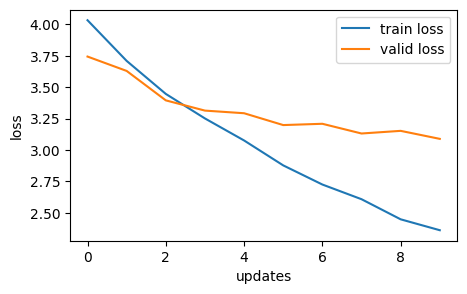

In [54]:
plot_loss(train_losses, valid_losses)

In [55]:
result_print(gen_train_loss, gen_val_loss)

Training loss : 2.362 | perplexity :  10.612
Validation loss : 3.089 | perplexity :  21.949


In [56]:
test_loop(genmodel)

| Test Loss: 3.279 | Test PPL:  26.536 |


## Multiplicative train

In [57]:
train_losses, valid_losses, mul_train_loss, mul_val_loss = train_loop(mulmodel, optimizer_mul, criterion_mul)

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.581 | Train PPL:  97.577
	 Val. Loss: 3.959 |  Val. PPL:  52.419
Epoch: 02 | Time: 0m 17s
	Train Loss: 3.834 | Train PPL:  46.253
	 Val. Loss: 3.605 |  Val. PPL:  36.787
Epoch: 03 | Time: 0m 18s
	Train Loss: 3.400 | Train PPL:  29.962
	 Val. Loss: 3.296 |  Val. PPL:  27.015
Epoch: 04 | Time: 0m 17s
	Train Loss: 3.088 | Train PPL:  21.933
	 Val. Loss: 3.170 |  Val. PPL:  23.807
Epoch: 05 | Time: 0m 16s
	Train Loss: 2.824 | Train PPL:  16.851
	 Val. Loss: 3.094 |  Val. PPL:  22.067
Epoch: 06 | Time: 0m 15s
	Train Loss: 2.572 | Train PPL:  13.096
	 Val. Loss: 2.940 |  Val. PPL:  18.921
Epoch: 07 | Time: 0m 17s
	Train Loss: 2.361 | Train PPL:  10.597
	 Val. Loss: 2.866 |  Val. PPL:  17.573
Epoch: 08 | Time: 0m 16s
	Train Loss: 2.150 | Train PPL:   8.585
	 Val. Loss: 2.904 |  Val. PPL:  18.242
Epoch: 09 | Time: 0m 15s
	Train Loss: 1.964 | Train PPL:   7.125
	 Val. Loss: 2.899 |  Val. PPL:  18.164
Epoch: 10 | Time: 0m 16s
	Train Loss: 1.803 | Train PPL

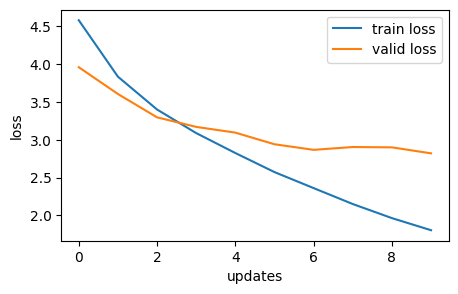

In [58]:
plot_loss(train_losses, valid_losses)

In [59]:
test_loop(mulmodel)

| Test Loss: 3.110 | Test PPL:  22.422 |


In [60]:
result_print(mul_train_loss, mul_val_loss)

Training loss : 2.820 | perplexity :  16.781
Validation loss : 1.803 | perplexity :   6.071


## Additive train

In [61]:
train_losses, valid_losses, add_train_loss, add_val_loss = train_loop(addmodel, optimizer_add, criterion_add)

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.540 | Train PPL:  93.725
	 Val. Loss: 3.955 |  Val. PPL:  52.188
Epoch: 02 | Time: 0m 17s
	Train Loss: 3.645 | Train PPL:  38.282
	 Val. Loss: 3.327 |  Val. PPL:  27.864
Epoch: 03 | Time: 0m 18s
	Train Loss: 3.108 | Train PPL:  22.371
	 Val. Loss: 3.117 |  Val. PPL:  22.583
Epoch: 04 | Time: 0m 17s
	Train Loss: 2.725 | Train PPL:  15.261
	 Val. Loss: 2.949 |  Val. PPL:  19.093
Epoch: 05 | Time: 0m 16s
	Train Loss: 2.414 | Train PPL:  11.184
	 Val. Loss: 2.893 |  Val. PPL:  18.053
Epoch: 06 | Time: 0m 17s
	Train Loss: 2.158 | Train PPL:   8.657
	 Val. Loss: 2.845 |  Val. PPL:  17.205
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.948 | Train PPL:   7.012
	 Val. Loss: 2.818 |  Val. PPL:  16.739
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.752 | Train PPL:   5.764
	 Val. Loss: 2.801 |  Val. PPL:  16.454
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.563 | Train PPL:   4.775
	 Val. Loss: 2.797 |  Val. PPL:  16.392
Epoch: 10 | Time: 0m 17s
	Train Loss: 1.419 | Train PPL

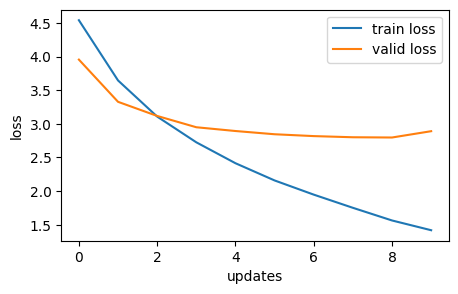

In [62]:
plot_loss(train_losses, valid_losses)

In [63]:
test_loop(addmodel)

| Test Loss: 3.032 | Test PPL:  20.734 |


In [64]:
result_print(add_train_loss, add_val_loss)

Training loss : 2.797 | perplexity :  16.392
Validation loss : 1.563 | perplexity :   4.775


# 5. Inference

## Generator function

In [2]:
mapping = {}
mapping[SRC_LANGUAGE] = vocab_transform[SRC_LANGUAGE].get_itos()
mapping[TRG_LANGUAGE] = vocab_transform[TRG_LANGUAGE].get_itos()

NameError: name 'vocab_transform' is not defined

In [3]:
def greedy_decode(model, src, max_len=50, device=device):
    src = text_transform[SRC_LANGUAGE](src).to(device).unsqueeze(0) # token >> vocab >> tensor
    model.eval()
    
    trg_indexes = [SOS_IDX]
    
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output, attentions = model(src, trg_tensor)
        
        pred_token = output.argmax(2)[:, -1].item()
        trg_indexes.append(pred_token)
        
        if pred_token == EOS_IDX:
            break
    
    # print(trg_indexes)
    trg_tokens = [mapping[TRG_LANGUAGE][i] for i in trg_indexes]
    return trg_tokens[1:], attentions  # Exclude the <sos> token


NameError: name 'device' is not defined

## General inference

In [67]:
save_path = f'./app/models/genmodel.pt'
genmodel.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [1]:
# Example usage
gen_src_sentence = "I go to school"

gen_output_sentence, gen_attentions = greedy_decode(genmodel, gen_src_sentence, max_len=50, device=device)
print("Predicted Sentence:", ' '.join(gen_output_sentence))

NameError: name 'greedy_decode' is not defined

## Multiplicative inference

In [70]:
save_path = f'./app/models/mulmodel.pt'
mulmodel.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [95]:
# Example usage
mul_src_sentence = "I love you"

mul_output_sentence, mul_attentions = greedy_decode(mulmodel, mul_src_sentence, max_len=50, device=device)
print("Predicted Sentence:", ' '.join(mul_output_sentence))

Predicted Sentence: ကျွန်တော် ဆေးလိပ် သောက် တယ် ။ <eos>


## Additive inference

In [72]:
save_path = f'./app/models/addmodel.pt'
addmodel.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [97]:
# Example usage
add_src_sentence = "I love you"

add_output_sentence, add_attentions = greedy_decode(addmodel, add_src_sentence, max_len=50, device=device)
print("Predicted Sentence:", ' '.join(add_output_sentence))

Predicted Sentence: ကျွန်တော် အမြဲတမ်း <unk> ပဲ စား နေ တယ် ။ <eos>


## Attention map

## Random sample for attention map

In [74]:
src_text = corpus['train'][0]['en']
trg_text = corpus['train'][0]['my']

In [75]:
trg_text

'မနေ့က အရက် နည်းနည်း သောက်ခဲ့တယ်။'

In [76]:
source = text_transform[SRC_LANGUAGE](src_text).to(device).unsqueeze(0)
target = text_transform[TRG_LANGUAGE](trg_text).to(device).unsqueeze(0)

In [83]:
with torch.no_grad():
    gen_output, gen_attentions = genmodel(source, target)
with torch.no_grad():
    mul_output, mul_attentions = mulmodel(source, target)
with torch.no_grad():
    add_output, add_attentions = addmodel(source, target)

In [84]:
def get_output(output):
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1)
    trg_tokens = ['<sos>'] + [mapping[TRG_LANGUAGE][token.item()] for token in output_max]
    return trg_tokens

In [85]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](src_text) + ['<eos>']

### Attention function

In [86]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [87]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    attention = attention[0, 0, :, :]
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks, name='Myanmar Text')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

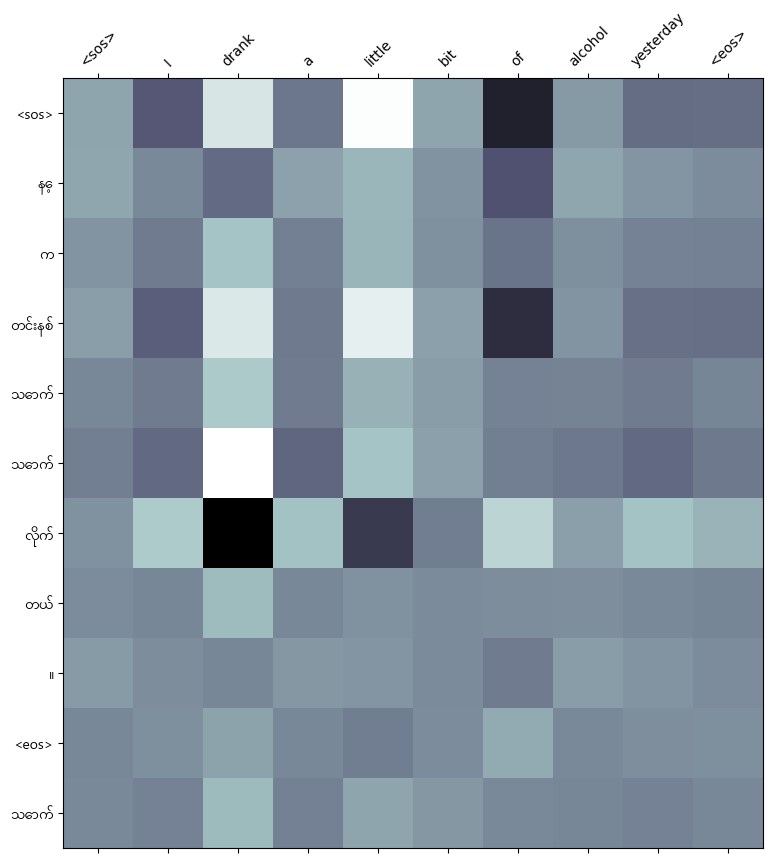

['<sos>', 'နေ့', 'က', 'တင်းနစ်', 'သောက်', 'သောက်', 'လိုက်', 'တယ်', '။', '<eos>', 'သောက်']


In [88]:
trg_tokens = get_output(gen_output)
display_attention(src_tokens, trg_tokens, gen_attentions)
print(trg_tokens)

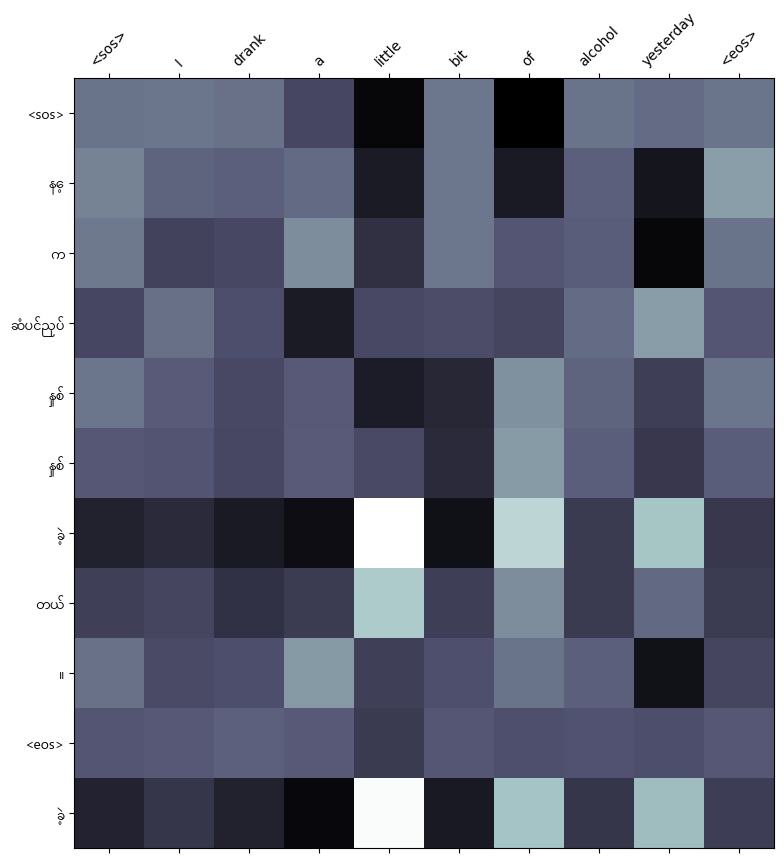

['<sos>', 'နေ့', 'က', 'ဆံပင်ညှပ်', 'နှစ်', 'နှစ်', 'ခဲ့', 'တယ်', '။', '<eos>', 'ခဲ့']


In [89]:
trg_tokens = get_output(mul_output)
display_attention(src_tokens, trg_tokens, mul_attentions)
print(trg_tokens)

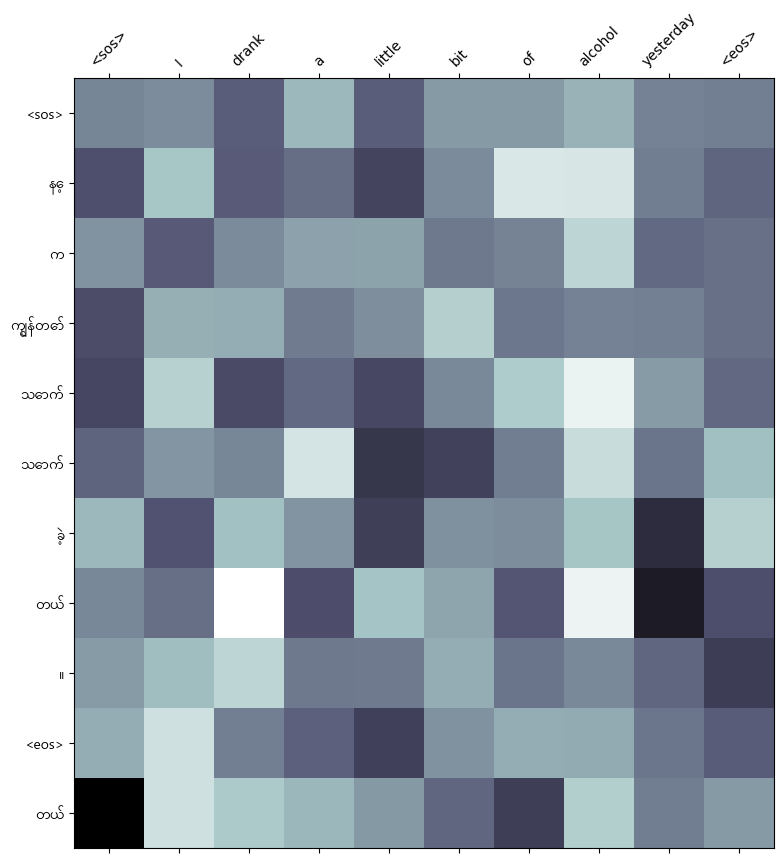

['<sos>', 'နေ့', 'က', 'ကျွန်တော်', 'သောက်', 'သောက်', 'ခဲ့', 'တယ်', '။', '<eos>', 'တယ်']


In [90]:
trg_tokens = get_output(add_output)
display_attention(src_tokens, trg_tokens, add_attentions)
print(trg_tokens)

## BLEU score

In [92]:
pip install nltk


  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl (274 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)


In [93]:
from nltk.translate.bleu_score import sentence_bleu

src_text = corpus['train'][89]['en']
trg_text = corpus['train'][89]['my']

src_token = token_transform[SRC_LANGUAGE](src_text)
trg_token = token_transform[TRG_LANGUAGE](trg_text)

print(sentence_bleu([src_token], trg_token))

0
